# Welcome to dymoval's tutorial!
 
In this tutorial we show the main functionalities of *dymoval*.

## DC Motor model
We assume that we built the model of a DC electric motor that we want to validate.
The dynamics of the actual DC motor that we want to capture are the connections between the *input* DC voltage and the motor speed, the DC current and the rotation angle that are considered as *outputs*.

<p align="center">
    <br>
  <img src="./DCMotor.svg" width="750" title="DCMotor" class="center">
</p>


### Validation setup
To validate our model we need to verify that its response is as close as possible to the actual DC motor response in front of the same *input* signal. Therefore, we need some **log data** and some **simulation data**.

We assume that we get some logs from the labs where a team run some experiments and collected the results in a `HDF5` file and that another team developed a DC motor model. Although such a team could also simulate the model by feeding it with the log data and provide us with just the simulation results, in this example we simulate the model by ourselves.


## Log data analysis
The first step is to extract the logs from the `HDF5` file and build a *dymoval* Dataset object.

Let's import some useful packages

In [1]:
# %matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import h5py
from copy import deepcopy
from itertools import product
import dymoval as dmv


>**Note:**
>If your notebook supports interactive plots, then you may uncomment the first line of the above code cell. 

Let's read the log data stored in the `hdf5` file. All the logs that we are interested in are stored in the group "*signals*".
Feel free to explore the hdf5 file at your convenience.
In this example, we use the h5py package to read it, but feel free to explore any other package that can read HDF5 files.

In [2]:
logs = h5py.File('./DCMotorLogs.h5', 'r')
logs["signals"].keys()

<KeysViewHDF5 ['V', 'dot_theta', 'ia', 'theta']>

We can extract the logged signals as it follows (see *h5py* docs for more info)

In [3]:
V = logs["signals/V"]
ia = logs["signals/ia"]
theta = logs["signals/theta"]
dot_theta = logs["signals/dot_theta"]

At this point we can cast the logs into *dymoval* `Signals`. 
Dymoval's `Signals` are utility Python `dict` (in reality they are `Typeddict`) used to represent signals. 

In [4]:
signal_list = []
for val in [V,ia,theta,dot_theta]:
    temp:dmv.Signal={
        "name" : val.attrs["name"].decode('utf-8'),
        "values" : val[:],
        "signal_unit" : val.attrs["unit"].decode('utf-8'),
        "sampling_period" : val.attrs["period"][0],
        "time_unit" : val.attrs["sampling_unit"].decode('utf-8'),
    }
    signal_list.append(deepcopy(temp))


Let's see how they look like

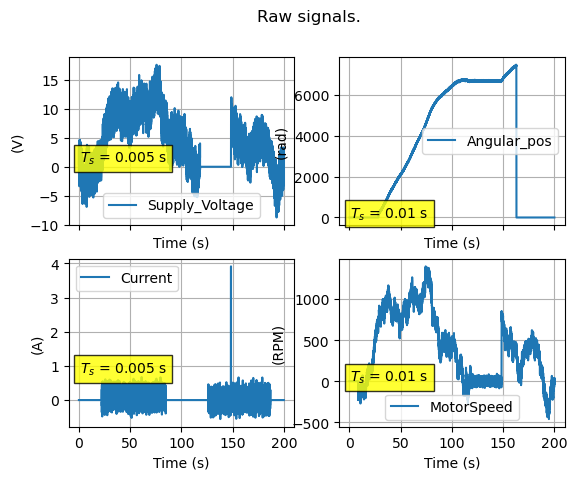

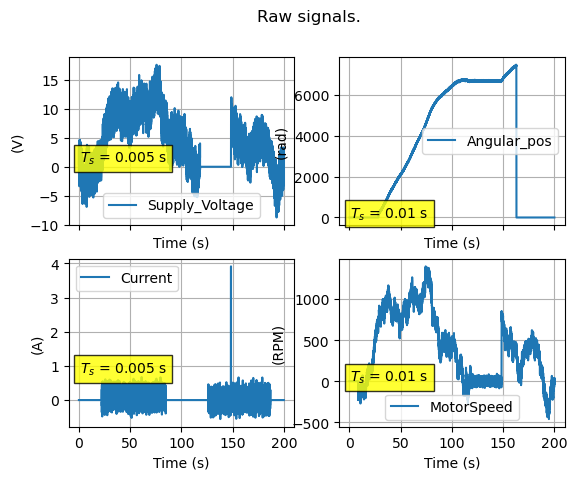

In [5]:
dmv.plot_signals(*signal_list)

As we can see, the signals have not been logged with the same sampling period and there is also some data logging interruption.
Well, things happen in the lab!

Nevertheless, a sound dataset shall have all the signals sampled with the same sampling period and it should not contains missing data. 
However, we can trim the signals in the time range e.g. $T = [30,80]\,s$ which seems a portion where no signal is missing data.

Finally, we can separate input and output signals and we can attempt to re-sample all of them with target sampling period equal to $0.01\,s$

In [6]:
signal_names = [s["name"] for s in signal_list]
u_names = signal_names[0]
y_names = signal_names[1:]
ds = dmv.Dataset(
    "DCMotor",
    signal_list,
    u_names,
    y_names,
    target_sampling_period=0.01,
    tin = 30,
    tout = 80.0
)

> If you don't use jupyer notebooks and are you are working in interactive mode, then you don't need to pass the arguments `tin` and `tout` but you can resize the figure graphically. The values of `tin` and `tout` will be automatically set when the figure is closed. 

When creating a *Dataset* object, the signals are always re-sampled in such a way that all of them will have the same sampling period, but sometimes this is not possible and therefore some signals may be excluded from the Dataset. 

The list of the excluded signals are stored in the attibute `excluded_signal`.

In [7]:
ds.excluded_signals

[]

As you can see, in this example all the signals have been correctly re-sampled and therefore there are no excluded signals.

Let's now take a look at how our Dataset looks like based on our selection. 

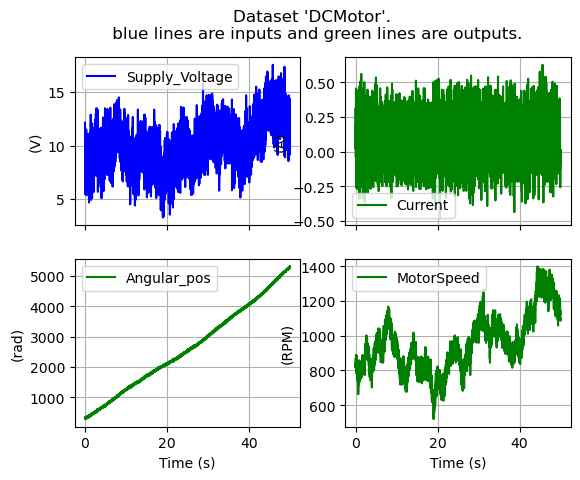

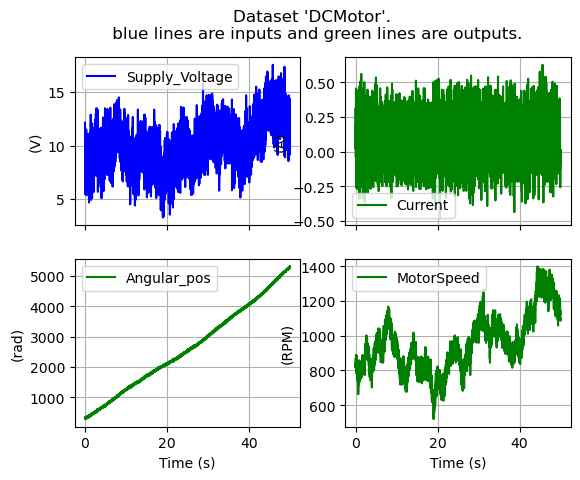

In [8]:
ds.plot()

...and let's check its coverage.

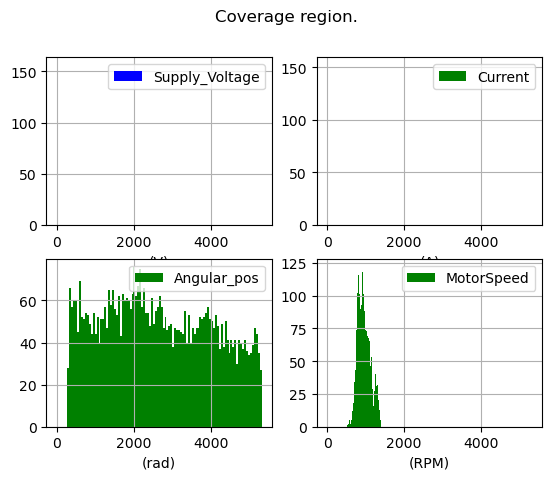

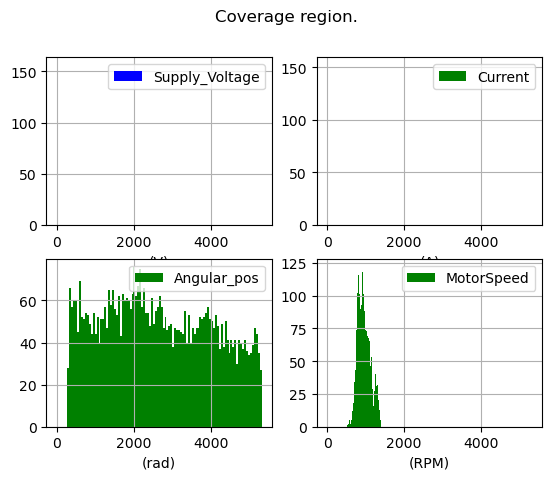

In [9]:
ds.plot_coverage()

As seen from the plot, the measurements are a bit noisy, so we may want to clean them up a little bit through a low pass filter.

However, we should find where to place the filter cutoff frequencies, and therefore it could be helpful to make a spectral analysis.
To do that we could first remove the continuous component through the `remove_means()` method, and then we can plot the spectrum through the method `plot_spectrum()`

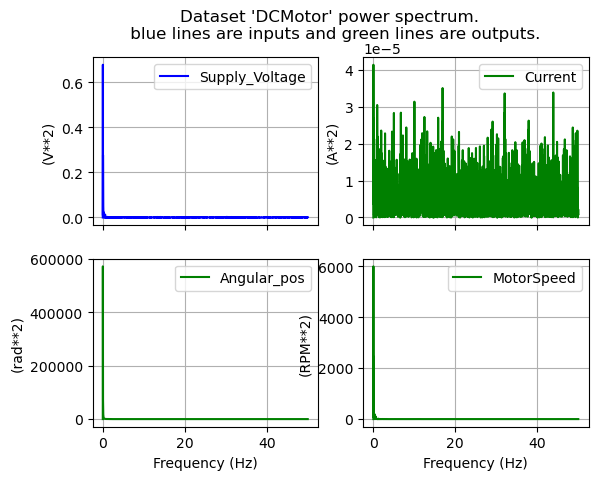

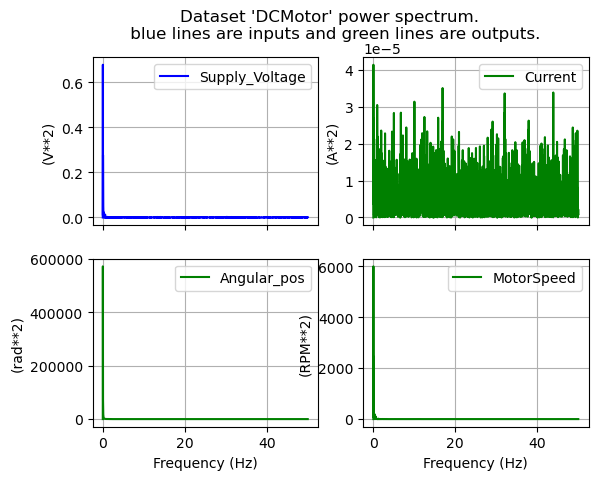

In [27]:
ds.remove_means().plot_spectrum()


As seen, all of the signals bandwidth is in contained very a narrow range $f < 1\, Hz$ and therefore we can think to low-pass filter the data. 
However, the smaller we take the cutoff frequency of the filter, the larger is the lag introduced to the filtered signal, so we have to find a good tradeoff. 

We can try with with a cutoff frequency $f_c = 5\, Hz$ and see what happens.

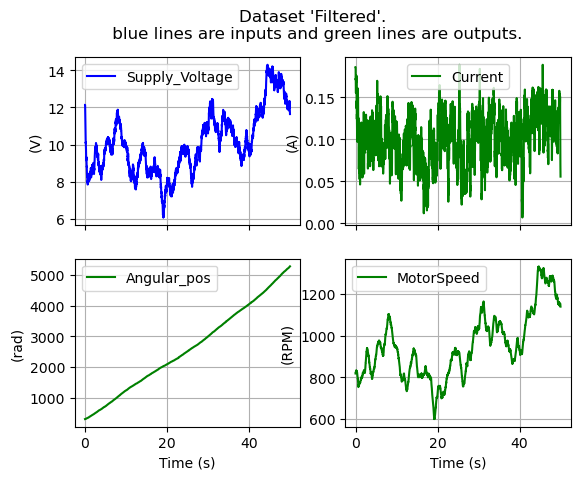

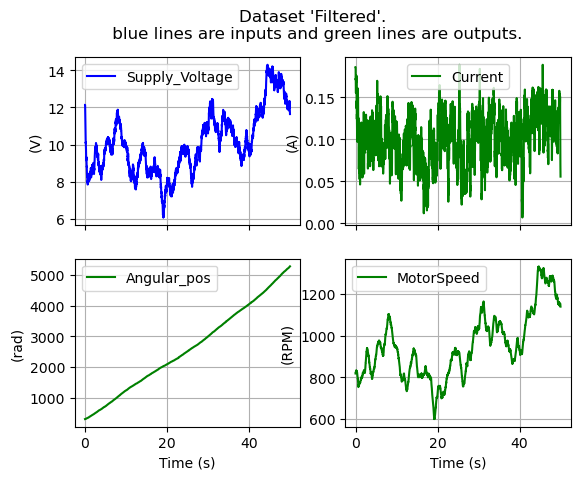

In [28]:
cutoff = 5  # [Hz]
signal_names = [s[1] for s in ds.signal_list()]
filter_bank = list(product(signal_names,[cutoff]))
ds_filt = ds.low_pass_filter(*filter_bank)
ds_filt.name = "Filtered"
ds_filt.plot()

Let's compare our datasets before and after the filtering. 

(<dymoval.dataset.Dataset object at 0x00000256E6FB1BA0>, <dymoval.dataset.Dataset object at 0x00000256ECA9AE30>)


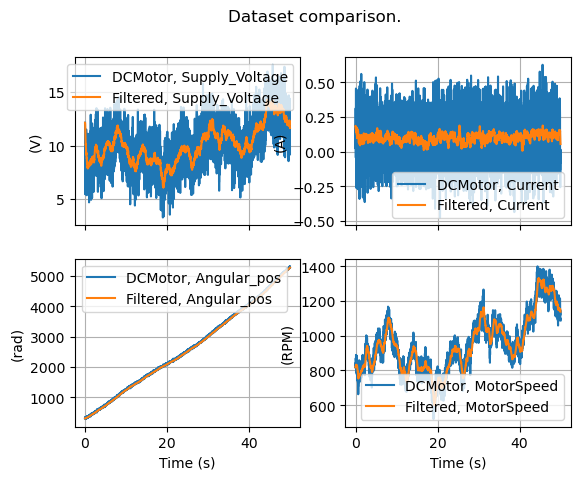

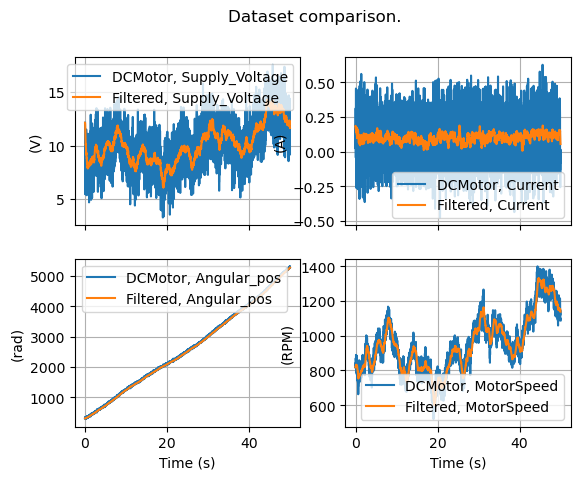

In [29]:
dmv.compare_datasets(ds,ds_filt)

The chosen cutoff frequency seems to clear most of the noise and it does not seem to intoduce too much lag. 

(<dymoval.dataset.Dataset object at 0x00000256E6FB1BA0>, <dymoval.dataset.Dataset object at 0x00000256ECA9AE30>)


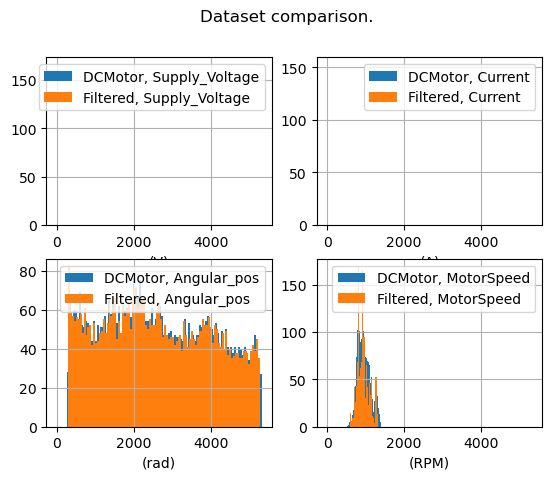

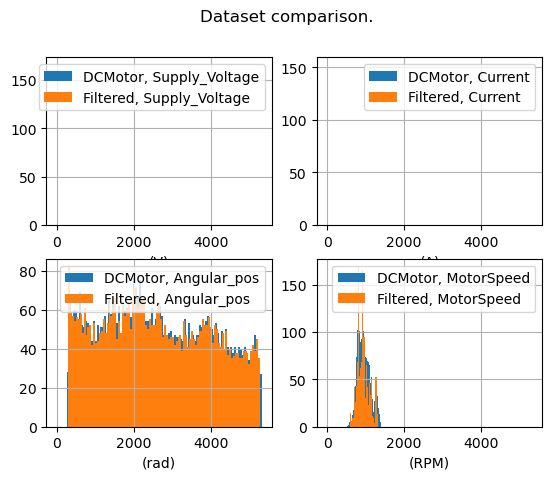

In [30]:
dmv.compare_datasets(ds,ds_filt, kind="coverage")

For each dataset, we can also see the coverage statistics in terms of mean value and covariance matrix

In [14]:
mean_in, cov_in, mean_out, cov_out = ds.coverage
mean_out

names        units
Current      A           0.1001
Angular_pos  rad      2641.5911
MotorSpeed   RPM       953.8554
dtype: float64

In [15]:
cov_out

,names,Current,Angular_pos,MotorSpeed
,units,A,rad,RPM
names,units,,,
Current,A,0.0253,1.011290e+01,2.0250
Angular_pos,rad,10.1129,1.961893e+06,153241.6818
MotorSpeed,RPM,2.0250,1.532417e+05,26490.4401


We can play around with `Dataset` objects with many other functions. 
For example we can selectively choose the signals that we want to plot or we can overlap them if we pass them as a tuple

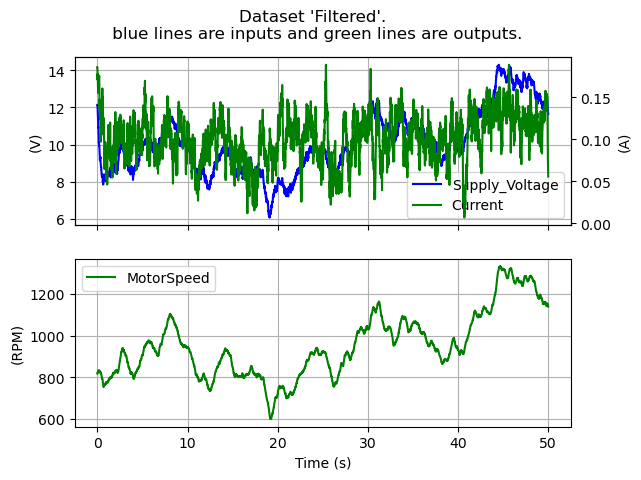

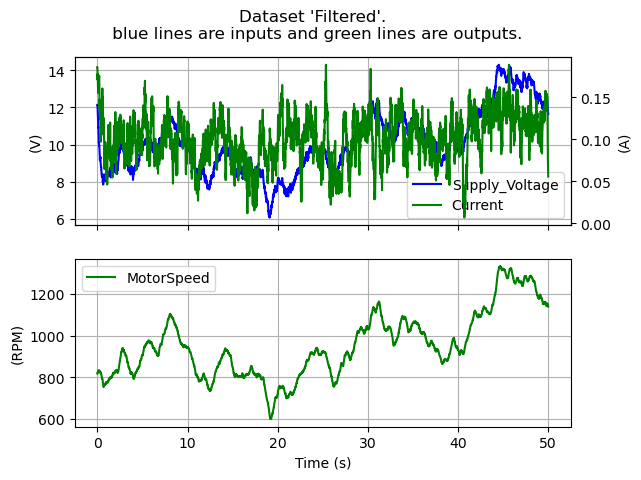

In [34]:
ds_filt.plot(("Supply_Voltage","Current"),"MotorSpeed")

Or we can plot them on an XY-plane

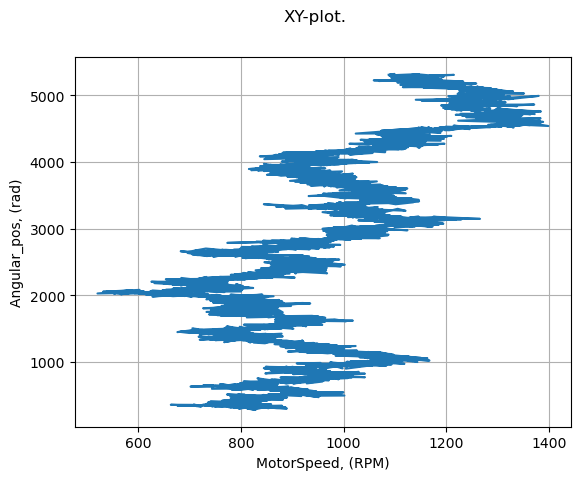

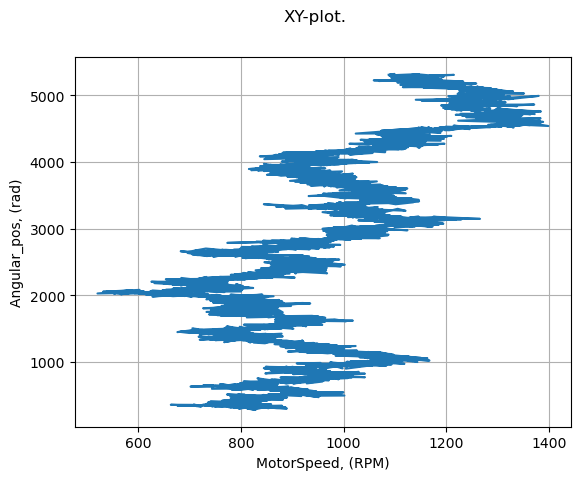

In [36]:

ds.plotxy(("MotorSpeed","Angular_pos"))

See *dymoval*'s [documentation](https://volvogroup.github.io/dymoval/) to discover more things you can do with a dymoval *Dataset*.

## Validation Session

Now that we have a "cleaned-up" *Dataset* object, we can validate our model.

First, we need to create a *ValidationSession* object from out Dataset object. 

In [16]:
vs = dmv.ValidationSession("DCMotor_val", ds_filt)

At this point, it is enough to simulate our model with the same input (which in our case is the logged voltage profile) stored in `ds_filt`. 

To do that we extract the numerical values of the input signal from the `Dataset` object

In [17]:
(t,u,y) = vs.Dataset.dataset_values()

Then, we load our model and we feed it with the extracted input `u` and then we store the model response to a variable `y_sim`

>Note that it is not required to run any model within Python, nor it is required the model to have a specific model format. You just need to import the  simulation results of your model (that you may have simulated elsewhere) and append such simulation results to a  *dymoval* ValidationSession object. But in this example we also simulate the model.

Let's import our model and let's simulate it

In [18]:
from  DCMotorModel import DCMotor_dt
import control as ct

# Simulate model
res = ct.forced_response(DCMotor_dt, U = u)
y_sim = res.y.T

Next, we append the simulation results `y_sim` to the *ValidationSession* object `vs`. 
The validation results are automatically computed. 

To append simulation results, we need to give a label to identify a simulation run and we shall also give a name to its output signals. 

In [19]:
# Append simulation
sim_name = "DCMotor_ss_model"
sim_labels = ["ia","theta","dot_theta"]
vs = vs.append_simulation(sim_name, sim_labels, y_sim)

In [20]:
vs.validation_results

,DCMotor_ss_model
r-square (%),73.7680
Residuals Auto-corr,1.5503
Input-Res. Cross-corr,1.0375


At this point we can compare the output of our model with the Dataset to have a first idea on how good our model is

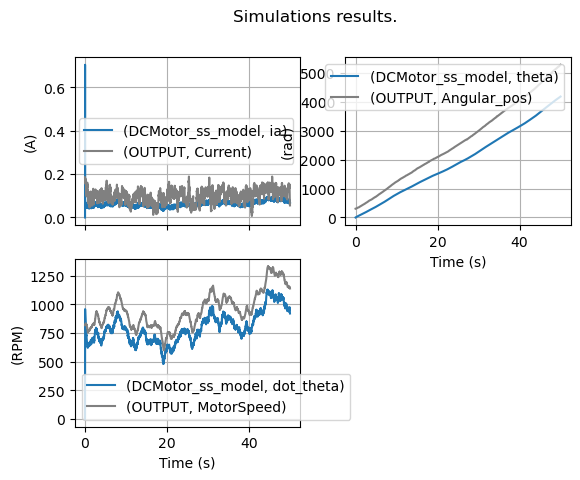

In [21]:
_=vs.plot_simulations(dataset='out')

Our model does not look too bad! 
But let's take a look at the validation metrics (which are just an attribute of the *ValidationSession* objects)

In [22]:
vs.validation_results

,DCMotor_ss_model
r-square (%),73.7680
Residuals Auto-corr,1.5503
Input-Res. Cross-corr,1.0375


The r-square fit looks not too bad and also the residuals norm are not terrible.
Let's take a visual inspection of the residuals.  

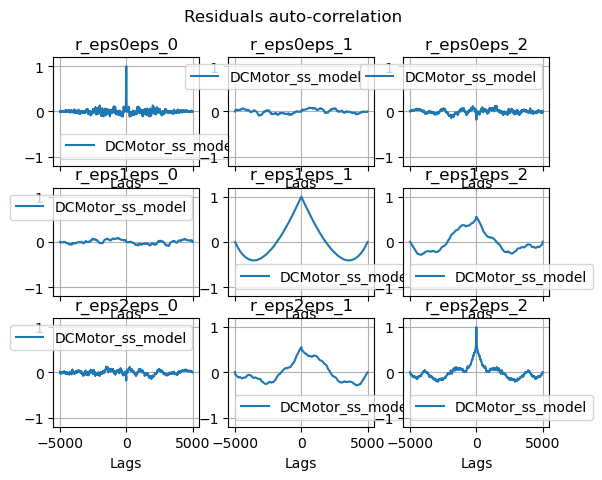

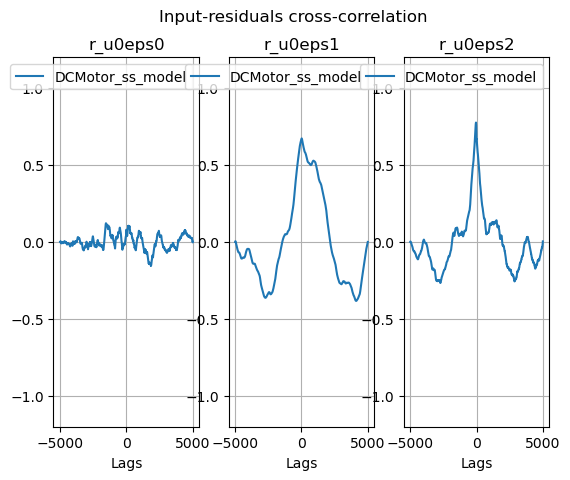

In [23]:
_ = vs.plot_residuals()

As we can see, the residuals plot are not too bad, but it seems that the input-residuals strongly depends on the input especially the *voltage -> rotation angle* and the the *voltage -> motor speed* residuals. 
Also, some auto-correlation plots look a bit... "*wide*". 
This suggests that there is still magin of improvements of our model, but yet the model looks usable, at least *qualitatively*.

That is, we can safely use this model for the first phases of development - and we won't have big surprises when testing in the target environment - but it also telling us that we should allocate some more time for further refinements to be done in the target environment. In other words the model is telling us: "I can help you as much as I can, but consider that you will have to spend some time in the target environment as well". 

*The more accurate is a model, the less time we will have to spend in the target environment to fix stuff.*

Although it is not perfect, this model certainly help us in saving a good portion of development and testing time and costs because we can carry out a reasonable large amount of work in a virtual enviroment with a certain amount of confidence, but keep in mind that this model provides guarantees only in its coverage region! 

## Few more notes

Congrats! You arrived at the end of the tutorial! 

Next, let me leave you some notes.

The main objects of *dymoval* are `Signals`, `Datasets` and `ValidationSessions`.
`Signals` are used as entry point from the external world to *dymoval*. We tried to keep them be as generic as possible.
`Datasets` are built upon *pandas* `DataFrames`. In-fact, the attribute `Dataset.dataset` is a pandas `DataFrame`:

In [24]:
ds_filt.dataset

kind               INPUT  OUTPUT                       
names     Supply_Voltage Current Angular_pos MotorSpeed
units                  V       A         rad        RPM
(Time, s)                                              
0.00             12.1347  0.1861    304.0536   818.2016
0.01             12.1347  0.1861    304.0536   818.2016
0.02             12.0942  0.1779    304.6723   819.4807
0.03             12.0063  0.1710    304.5956   819.3258
0.04             11.8551  0.1781    305.0709   819.5925
...                  ...     ...         ...        ...
49.96            11.8666  0.0774   5272.9372  1147.6021
49.97            11.8442  0.0700   5274.2131  1145.3375
49.98            11.7355  0.0625   5274.4469  1143.1478
49.99            11.6428  0.0589   5276.3141  1140.4951
50.00            11.6428  0.0556   5278.5030  1138.4204

[5001 rows x 4 columns]

This means that in principle, you could use all the pandas `DataFrame` methods in dymoval.

Although this can be useful for performing more thoroughly analysis of the dataset, to directly change the values of a `Dataset.dataset` `DataFrame` is discouraged since a dymoval `Dataset` object has additional attributes such as coverage regions, *NaN* intervals, excluded signals and so on, that depends on the `dataset` attribute itself. 

Hence, to keep consistency, if you directly change the `Datase.dataset` attribute of a `Dataset` object, then you should update also the other attributes accordingly and that may become very messy. 
If you need to change a `Dataset` object, just create a new one.

In the same way, a `Dataset` object is an attribute of a `ValidationSession`:

In [25]:
type(vs.Dataset)

dymoval.dataset.Dataset

This means that you can access all the methods and attributes of the stored `Dataset` object directly from a `ValidationSession` object.

But, again, it is discouraged to make any change directly to the `Dataset` object stored in a `ValidationSession` object. 
If you need a `ValidationSession` object with a different `Dataset`, just create a new one. 

## What's next?

Feel free to check the [documentation](https://volvogroup.github.io/dymoval/) to have access to the full API and to get more insight on how *dymoval* is structured.

Good luck!

# Credits
Picture from Mika Baumeister on Unsplash.